In [ ]:
"""
    This cell imports the packages used.
"""
import pandas as pd
import numpy as np
import math
import os
import time
from datetime import datetime,timedelta
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras import backend as kb

import warnings
warnings.filterwarnings("ignore")





In [ ]:
class FBNNOptionPricing():


    def __init__(self,
                 data,
                 feature_names,
                 target,
                 alpha = 10**(-3),
                 beta = 1,
                 hidden_nodes = [32, 16],
                 learning_rate = 0.001,
                 batch_size = 512):
        """
            __init__ defines all the variables and functions used.
            E.g. alpha and beta are the regularization parameters.
        """
      
        self.data = data
        self.hidden_nodes = hidden_nodes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        
        #Checking that the inputs are correctly given
        if feature_names != None and target != None:
            self.feature_names = feature_names
            self.target = target
        else:
            raise ValueError('Please provide the features and the target')

        #Create the inputs for the Fully Bayesian Neural Network
        self.model_inputs = self.create_model_inputs(self.feature_names)

        #Initialze the FBayesianNeuralNet()
        self.FBayesianNeuralNet = FBayesianNeuralNet(hidden_nodes, learning_rate, batch_size)
        self.model = self.FBayesianNeuralNet.create_fbnn_model(len(self.data), self.model_inputs)

    def df_to_dataset(self, data_bin = False, data = None, shuffle = True):
        '''
            This function converts the given data (Pandas Dataframe) into a 
            tensorflow data which is needed as a input for the Neural Network.
        '''
        temp = self.feature_names + [self.target]
        dataframe = data[temp].copy()
        labels = dataframe.pop(self.target)
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(self.batch_size)
        return ds

    def create_model_inputs(self, features):
        """
            This function returns the model inputs (in our case: Moneyness and Maturity)
            for the Neural Network.
        """
        inputs = {}
        for feature_name in features:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(1,), dtype=tf.float32
            )
        return inputs

    def custom_loss_function(self, y_true, y_pred):
        """
            The custom_loss_function returns the loss value for our specified loss function. 
            self.beta is the regularization parameter.
            The loss function can be found in the Bayesian Neural Network section in our report.
        """
        return self.beta*kb.sum(kb.square(y_true - y_pred))

    def compile_fbnn(self):
        """
            Here the Neural Network is compiled with the optimizer, loss function 
            and we also define RMSE as metric.
        """
        self.model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate = self.FBayesianNeuralNet.learning_rate),
            loss = self.custom_loss_function,
            metrics=[keras.metrics.RootMeanSquaredError()],
        )

    def train_and_evaluate_fbnn(self, num_epochs, train_data = None, val_data = None):
        """
            This function trains the model on th training data and validation data 
            with the specified numbers of epochs.
        """
        self.compile_fbnn()
        print("Start training the model...")
        self.model.fit(train_data, epochs=num_epochs, validation_data=val_data, verbose = 2)
        print("Model training finished.")
        
    def create_est_train_test(self, period):
        """
            This function splits the data in training, validation and test data for the estimation errors.
        """
        if period == 'pre-crisis':
            train = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2006,7,1))]
            val = self.data[(self.data['date'] >= pd.Timestamp(2006,7,1)) & (self.data['date'] < pd.Timestamp(2007,1,1))]
            test = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2007,1,1))]
        elif period == 'crisis':
            train = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2009,7,1))]
            val = self.data[(self.data['date'] >= pd.Timestamp(2009,7,1)) & (self.data['date'] < pd.Timestamp(2010,1,1))]
            test = self.data[(self.data['date'] >= pd.Timestamp(2007,1,1)) & (self.data['date'] < pd.Timestamp(2010,1,1))]
        elif period == 'post-crisis':
            train = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2012,7,1))]
            val = self.data[(self.data['date'] >= pd.Timestamp(2012,7,1)) & (self.data['date'] < pd.Timestamp(2013,1,1))]
            test = self.data[(self.data['date'] >= pd.Timestamp(2010,1,1)) & (self.data['date'] < pd.Timestamp(2013,1,1))]
        else:
            raise ValueError('Not a valid string for period')
        return train, val, test


    def create_pred_train_test(self, period):
        """
            This function splits the data in training, validation and test data for the prediction errors.
            The prediction period is about half a year.
        """
        if period == 'pre-crisis':
          train = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2006,1,1))]
          val = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2006,7,1))]
          test = self.data[(self.data['date'] >= pd.Timestamp(2006,7,1)) & (self.data['date'] < pd.Timestamp(2007,1,1))]
        elif period == 'crisis':
          train = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2009,1,1))]
          val = self.data[(self.data['date'] >= pd.Timestamp(2009,1,1)) & (self.data['date'] < pd.Timestamp(2009,7,1))]
          test = self.data[(self.data['date'] >= pd.Timestamp(2009,7,1)) & (self.data['date'] < pd.Timestamp(2010,1,1))]
        elif period == 'post-crisis':
          train = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2012,1,1))]
          val = self.data[(self.data['date'] >= pd.Timestamp(2012,1,1)) & (self.data['date'] < pd.Timestamp(2012,7,1))]
          test = self.data[(self.data['date'] >= pd.Timestamp(2012,7,1)) & (self.data['date'] < pd.Timestamp(2013,1,1))]
        else:
          raise ValueError('Not a valid string for period')
        return train, val, test
                

    def cal_prediction_errors(self, epochs, period = None, iterations = 50):
        '''
            The cal_prediction_errors function is actually one of the main functions which combines a lot of 
            other (pre-)defined functions to calculate the prediction error. The Fully Bayesian Neural Network is
            trained in this function and thereafter, the prices are predicted and the errors are calculated.
        '''
        print('Model cannot be trained beforehand - delete trained model before calling this function!')
        temp = self.feature_names + [self.target]
        pred = 0
        train, val, test = self.create_pred_train_test(period)
        train_ds = self.df_to_dataset(data_bin = True, data = train)
        val_ds = self.df_to_dataset(data_bin = True, data = val)

        self.train_and_evaluate_fbnn(epochs, train_data = train_ds, val_data = val_ds)
        
        dataset_period_pred = self.df_to_dataset(data_bin = True, data = test[temp], shuffle = False)
        feat, targets = list(dataset_period_pred.unbatch().batch(len(test)))[0]
        targets = targets.numpy()
        for i in range(0, iterations):
            pred += self.model(feat).numpy()
        rmse = math.sqrt(np.mean((pred*(1/iterations) - targets[0:, None])**2))
        mape = np.mean(np.abs(pred*(1/iterations) - targets[0:, None])/targets[0:, None])

        print('Prediction Error - RMSE: ' + str(rmse), 'MAPE: ' + str(mape))

        return pred*(1/iterations), test.index, rmse, mape

        
    def cal_estimation_errors(self, epochs, period = None, iterations = 50):
        """
            This function is doing about the same as the cal_prediction_error function but for the 
            estimation errors.
        """
        print('Model cannot be trained beforehand - delete trained model before calling this function!')
        temp = self.feature_names + [self.target]
        pred = 0
        train, val, test = self.create_est_train_test(period)
        train_ds = self.df_to_dataset(data_bin = True, data = train)
        val_ds = self.df_to_dataset(data_bin = True, data = val)

        self.train_and_evaluate_fbnn(epochs, train_data = train_ds, val_data = val_ds)


        dataset_period_pred = self.df_to_dataset(data_bin = True, data = test[temp], shuffle = False)
        feat, targets = list(dataset_period_pred.unbatch().batch(len(test)))[0]
        targets = targets.numpy()

        for i in range(0, iterations):
            pred += self.model(feat).numpy()


        rmse = math.sqrt(np.mean((pred*(1/iterations) - targets[0:, None])**2))
        mape = np.mean(np.abs(pred*(1/iterations) - targets[0:, None])/targets[0:, None])

        print('Estimation Error - RMSE: ' + str(rmse), 'MAPE: ' + str(mape))

        return pred*(1/iterations), test.index, rmse, mape

In [ ]:
class FBayesianNeuralNet():


    def __init__(self,
                 hidden_nodes,
                 learning_rate,
                 batch_size = 512,
                 alpha = 10**(-3),
                 loss = None):
      
        '''
            The init function defines the variables used in the Fully Bayesian Neural Network.
        '''
        self.hidden_nodes = hidden_nodes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.alpha = alpha

        if loss == None:
          self.loss = keras.losses.MeanSquaredError()
        else:
          self.loss = loss
           

    def prior(self, kernel_size, bias_size, dtype = None):
        '''
            The prior is a non-trainable multivariate normal distribution with
            the identity matrix as covariance. 
        '''
        n = kernel_size + bias_size
        prior_model = keras.Sequential(
            [
                tfp.layers.DistributionLambda(
                    lambda t: tfp.distributions.MultivariateNormalDiag(
                        loc=tf.zeros(n), scale_diag=tf.ones(n)
                    )
                )
            ]
          )
        return prior_model


    def posterior(self, kernel_size, bias_size, dtype=None):
        '''
            The posterior is defined as described in our report (section FBNN). 
            It is a "surrogate" posterior where the mean and the full covariance matrix is trainable.
        '''
        alpha = 10**(-3)
        n = kernel_size + bias_size
        posterior_model = keras.Sequential(
            [
                tfp.layers.VariableLayer(
                    tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype #, regularizer = tf.keras.regularizers.l2(alpha)
                ),
                tfp.layers.MultivariateNormalTriL(n),
            ]
        )
        return posterior_model

    
    def create_fbnn_model(self, train_size, inputs):
        '''
            This function creates the Fully Bayesian Neural Network as described in our paper.
            The above defined prior and posterior are used.
        '''
        features = keras.layers.concatenate(list(inputs.values()))
        features = layers.BatchNormalization()(features)

        layer_dict = {}
        i = 0
        for units in self.hidden_nodes:
            temp = tfp.layers.DenseVariational(
                units=units,
                make_prior_fn = self.prior,
                make_posterior_fn = self.posterior,
                kl_weight=1 / train_size,
                activation="relu"
            )
            layer_dict[i] = temp
            features = temp(features)
            i += 1

        outputs = layers.Dense(units=1, activation='linear', 
                               kernel_regularizer = tf.keras.regularizers.l2(self.alpha),
                               bias_regularizer = tf.keras.regularizers.l2(self.alpha))(features)
        model = keras.Model(inputs=inputs, outputs=outputs)

        for j in range(0, len(self.hidden_nodes)):
            model.add_loss(lambda: self.alpha * tf.math.reduce_sum(tf.square(layer_dict[j].non_trainable_weights)))

        return model

#**Data preparation**

In [ ]:
option_data = pd.read_csv("/Users/svenspa/Downloads/data aqf/oex option data 2000-2020.csv")
underlying_data=pd.read_csv("/Users/svenspa/Downloads/data aqf/oex underlying.csv")
interest_rate_data=pd.read_csv("/Users/svenspa/Downloads/data aqf/yield curve.csv")
option_data_european = pd.read_csv("/Users/svenspa/Downloads/data aqf/xeo option data 2002-2020.csv")
underlying_data[['date']] = pd.to_datetime(underlying_data['date'],format='%Y%m%d')
underlying_data['date'] = underlying_data["date"].dt.date
interest_rate_data[['date']] = pd.to_datetime(interest_rate_data['date'],format='%Y%m%d')
interest_rate_data['date'] = interest_rate_data["date"].dt.date

In [ ]:
def process_data(option_data,underlying_data,interest_rate_data,is_American):
  #Remove options with the wrong date
  min_date=20030101
  max_date=20121231
  option_data=option_data[(option_data['date'] >= min_date) & (option_data['date'] <= max_date)]

  #Remove options below a certain volume
  min_volume=1
  option_data=option_data[option_data['volume'] >= min_volume]

  #Remove call options
  option_data=option_data[ option_data['cp_flag'] == "P" ]

  #Create a time to maturity column (in trading days)
  option_data[['date']] = pd.to_datetime(option_data['date'],format='%Y%m%d')
  option_data['date'] = option_data["date"].dt.date
  option_data[['exdate']] = pd.to_datetime(option_data['exdate'],format='%Y%m%d')
  option_data['exdate'] = option_data["exdate"].dt.date
  if(is_American):
    option_data[['last_date']] = pd.to_datetime(option_data['last_date'],format='%Y%m%d')
    option_data['last_date'] = option_data["last_date"].dt.date
  option_data['maturity']=np.busday_count(option_data['date'],option_data['exdate'], weekmask='1111111') #Do we have to include weekends?

  #Remove options that do not have correct maturity
  min_maturity=7
  max_maturity=90
  option_data = option_data[(option_data['maturity'] <= max_maturity) & (option_data['maturity'] >= min_maturity)]

  #Create a column with market prices
  option_data['market price'] = (option_data['best_bid'] + option_data['best_offer'])/2

  #Add the underlying to the dataframe
  rows=option_data.shape[0]
  underlying_vec=np.empty(rows, dtype=object)
  date_selector=0
  row_number=0
  for index, row in option_data.iterrows():
    while (underlying_data.at[date_selector,'date']!=row['date']):
      date_selector=date_selector+1
    underlying_vec[row_number]=underlying_data.at[date_selector,'close']
    row_number=row_number+1
  option_data['underlying']=underlying_vec

  #Create columns moneyness and time value
  option_data['moneyness'] = option_data['underlying'] / option_data['strike_price'] * 1000
  option_data['time value'] =  option_data['market price'] - (option_data['strike_price']/1000 - option_data['underlying'])

  #Create column with forward volume
  option_data['1d forward volume'] = option_data.groupby(['optionid'])['volume'].shift(-1)

  #Cleaning based on Ruf and Wang 2020 (https://github.com/weiguanwang/Hedging_Neural_Networks/tree/74d5a7b72626e92395d056ced01cb8e135edcbcc)
  option_data.dropna(subset=['impl_volatility'], how='any', inplace=True)
  option_data = option_data[(option_data['impl_volatility'] < 1) & (option_data['impl_volatility'] > 0.01)] 
  option_data = option_data[option_data['volume'] > 0]
  option_data = option_data[option_data['best_bid'] > 0.05]
  option_data = option_data[(option_data['time value']> 0)]
  option_data = option_data[ (2*option_data['best_bid'] > option_data['best_offer'])]
  option_data = option_data[~option_data['1d forward volume'].isna()]
  if(is_American):
    option_data = option_data[option_data['last_date'] == option_data['date']]

  #Add the interest to the dataframe -> maybe should scale it somehow
  rows=option_data.shape[0]
  interest_rate_vec=np.empty(rows, dtype=object)
  date_selector=0
  row_number=0
  for index, row in option_data.iterrows():
    while (interest_rate_data.at[date_selector,'date']<row['date']): #There are dates where options are traded, but no interest is quoted
      date_selector=date_selector+1
      if date_selector>=216968:
        print(date_selector)
        print(interest_rate_data.at[date_selector,'date'])
        print(row['date'])
    i=0
    while (interest_rate_data.at[date_selector+i,'days']<row['maturity']):
      i=i+1
    left_gap=row['maturity']-interest_rate_data.at[date_selector+i-1,'days']
    right_gap=interest_rate_data.at[date_selector+i,'days']-row['maturity']
    if left_gap<right_gap:
      i=i-1
    interest_rate_vec[row_number]=interest_rate_data.at[date_selector+i,'rate']
    row_number=row_number+1
  option_data['interest_rate']=interest_rate_vec

  option_data['maturity']=option_data['maturity']/250
  option_data['strike_price']=option_data['strike_price']/1000

  #Converting some of the columns from objects back to float values
  option_data = option_data.astype({'moneyness': 'float64'})

  option_data = option_data.reset_index(drop=True)

  return option_data

In [ ]:
option_data=process_data(option_data,underlying_data,interest_rate_data,True)
option_data_european=process_data(option_data_european,underlying_data,interest_rate_data,False)

#**Calibration and Evaluation of FBayesianOptionPricing**

In [ ]:
pricevecEst = np.empty((103496,1))
pricevecEst[:] = np.NaN
for per in ['pre-crisis','crisis','post-crisis']:
    BOP = FBayesianOptionPricing(option_data, 
                              ['moneyness','maturity'],
                              'market price',
                              hidden_nodes = [32, 32],
                              learning_rate = 0.01,
                              batch_size = 256,
                              alpha=1,
                              beta = 0.000001)
    predvec, index, rmse, mape = BOP.cal_estimation_errors(period=per, epochs = 500)
    del BOP.model
    pricevecEst[index] = predvec

Model cannot be trained beforehand - delete trained model before calling this function!
Start training the model...
Epoch 1/500
122/122 - 4s - loss: 0.1244 - root_mean_squared_error: 20.6812 - val_loss: 0.0421 - val_root_mean_squared_error: 9.7061
Epoch 2/500
122/122 - 2s - loss: 0.0523 - root_mean_squared_error: 10.7306 - val_loss: 0.0493 - val_root_mean_squared_error: 8.7955
Epoch 3/500
122/122 - 2s - loss: 0.0588 - root_mean_squared_error: 10.2844 - val_loss: 0.0497 - val_root_mean_squared_error: 7.0621
Epoch 4/500
122/122 - 2s - loss: 0.0701 - root_mean_squared_error: 10.5287 - val_loss: 0.0603 - val_root_mean_squared_error: 6.4579
Epoch 5/500
122/122 - 1s - loss: 0.0714 - root_mean_squared_error: 9.8569 - val_loss: 0.0606 - val_root_mean_squared_error: 6.6452
Epoch 6/500
122/122 - 2s - loss: 0.0730 - root_mean_squared_error: 9.0735 - val_loss: 0.0648 - val_root_mean_squared_error: 5.8711
Epoch 7/500
122/122 - 2s - loss: 0.0837 - root_mean_squared_error: 10.2960 - val_loss: 0.0810 

Epoch 63/500
122/122 - 2s - loss: 0.0946 - root_mean_squared_error: 9.5433 - val_loss: 0.0864 - val_root_mean_squared_error: 7.0796
Epoch 64/500
122/122 - 2s - loss: 0.0892 - root_mean_squared_error: 8.6392 - val_loss: 0.0829 - val_root_mean_squared_error: 6.0891
Epoch 65/500
122/122 - 1s - loss: 0.0985 - root_mean_squared_error: 10.3717 - val_loss: 0.0859 - val_root_mean_squared_error: 6.8085
Epoch 66/500
122/122 - 1s - loss: 0.0900 - root_mean_squared_error: 8.7526 - val_loss: 0.0841 - val_root_mean_squared_error: 7.7838
Epoch 67/500
122/122 - 1s - loss: 0.0921 - root_mean_squared_error: 9.3636 - val_loss: 0.0909 - val_root_mean_squared_error: 8.9040
Epoch 68/500
122/122 - 1s - loss: 0.0964 - root_mean_squared_error: 9.9927 - val_loss: 0.0917 - val_root_mean_squared_error: 9.0269
Epoch 69/500
122/122 - 1s - loss: 0.0955 - root_mean_squared_error: 9.7788 - val_loss: 0.0824 - val_root_mean_squared_error: 7.3466
Epoch 70/500
122/122 - 2s - loss: 0.1026 - root_mean_squared_error: 11.1750

Epoch 125/500
122/122 - 2s - loss: 0.0947 - root_mean_squared_error: 9.3815 - val_loss: 0.0828 - val_root_mean_squared_error: 6.4384
Epoch 126/500
122/122 - 1s - loss: 0.0944 - root_mean_squared_error: 9.3589 - val_loss: 0.0805 - val_root_mean_squared_error: 7.1798
Epoch 127/500
122/122 - 1s - loss: 0.0934 - root_mean_squared_error: 9.4469 - val_loss: 0.0810 - val_root_mean_squared_error: 6.5268
Epoch 128/500
122/122 - 1s - loss: 0.0962 - root_mean_squared_error: 10.0392 - val_loss: 0.0852 - val_root_mean_squared_error: 7.9988
Epoch 129/500
122/122 - 1s - loss: 0.0925 - root_mean_squared_error: 9.1742 - val_loss: 0.0827 - val_root_mean_squared_error: 7.2432
Epoch 130/500
122/122 - 1s - loss: 0.0881 - root_mean_squared_error: 8.5269 - val_loss: 0.0836 - val_root_mean_squared_error: 6.5209
Epoch 131/500
122/122 - 1s - loss: 0.0956 - root_mean_squared_error: 9.8116 - val_loss: 0.0792 - val_root_mean_squared_error: 6.7832
Epoch 132/500
122/122 - 1s - loss: 0.0962 - root_mean_squared_error:

Epoch 187/500
122/122 - 1s - loss: 0.0895 - root_mean_squared_error: 9.1272 - val_loss: 0.0778 - val_root_mean_squared_error: 6.2547
Epoch 188/500
122/122 - 1s - loss: 0.0951 - root_mean_squared_error: 9.7795 - val_loss: 0.0809 - val_root_mean_squared_error: 5.8872
Epoch 189/500
122/122 - 2s - loss: 0.0962 - root_mean_squared_error: 10.1279 - val_loss: 0.0773 - val_root_mean_squared_error: 6.0886
Epoch 190/500
122/122 - 2s - loss: 0.0998 - root_mean_squared_error: 10.9398 - val_loss: 0.0798 - val_root_mean_squared_error: 6.1563
Epoch 191/500
122/122 - 1s - loss: 0.0857 - root_mean_squared_error: 8.1569 - val_loss: 0.0913 - val_root_mean_squared_error: 8.5558
Epoch 192/500
122/122 - 1s - loss: 0.0951 - root_mean_squared_error: 10.1043 - val_loss: 0.0770 - val_root_mean_squared_error: 5.7771
Epoch 193/500
122/122 - 1s - loss: 0.0924 - root_mean_squared_error: 9.4456 - val_loss: 0.0783 - val_root_mean_squared_error: 5.8720
Epoch 194/500
122/122 - 2s - loss: 0.0892 - root_mean_squared_erro

Epoch 249/500
122/122 - 2s - loss: 0.0876 - root_mean_squared_error: 9.1027 - val_loss: 0.0738 - val_root_mean_squared_error: 5.6549
Epoch 250/500
122/122 - 2s - loss: 0.0865 - root_mean_squared_error: 9.0640 - val_loss: 0.0732 - val_root_mean_squared_error: 5.5810
Epoch 251/500
122/122 - 2s - loss: 0.0855 - root_mean_squared_error: 8.5016 - val_loss: 0.0811 - val_root_mean_squared_error: 7.4496
Epoch 252/500
122/122 - 2s - loss: 0.0861 - root_mean_squared_error: 8.9262 - val_loss: 0.0854 - val_root_mean_squared_error: 9.3571
Epoch 253/500
122/122 - 2s - loss: 0.0867 - root_mean_squared_error: 8.9322 - val_loss: 0.0861 - val_root_mean_squared_error: 7.8703
Epoch 254/500
122/122 - 2s - loss: 0.0904 - root_mean_squared_error: 9.6208 - val_loss: 0.0789 - val_root_mean_squared_error: 7.4744
Epoch 255/500
122/122 - 2s - loss: 0.0869 - root_mean_squared_error: 8.9435 - val_loss: 0.0903 - val_root_mean_squared_error: 9.7451
Epoch 256/500
122/122 - 2s - loss: 0.0881 - root_mean_squared_error: 

Epoch 311/500
122/122 - 2s - loss: 0.0808 - root_mean_squared_error: 8.4672 - val_loss: 0.0731 - val_root_mean_squared_error: 4.5170
Epoch 312/500
122/122 - 2s - loss: 0.0870 - root_mean_squared_error: 9.1331 - val_loss: 0.0701 - val_root_mean_squared_error: 6.1226
Epoch 313/500
122/122 - 2s - loss: 0.0818 - root_mean_squared_error: 8.5719 - val_loss: 0.0753 - val_root_mean_squared_error: 6.3390
Epoch 314/500
122/122 - 2s - loss: 0.0805 - root_mean_squared_error: 8.3274 - val_loss: 0.0707 - val_root_mean_squared_error: 5.9306
Epoch 315/500
122/122 - 2s - loss: 0.0816 - root_mean_squared_error: 8.2844 - val_loss: 0.0741 - val_root_mean_squared_error: 7.4003
Epoch 316/500
122/122 - 2s - loss: 0.0787 - root_mean_squared_error: 7.9938 - val_loss: 0.0878 - val_root_mean_squared_error: 9.5814
Epoch 317/500
122/122 - 2s - loss: 0.0838 - root_mean_squared_error: 8.8833 - val_loss: 0.0701 - val_root_mean_squared_error: 5.3248
Epoch 318/500
122/122 - 2s - loss: 0.0848 - root_mean_squared_error: 

Epoch 373/500
122/122 - 2s - loss: 0.0625 - root_mean_squared_error: 5.1556 - val_loss: 0.0563 - val_root_mean_squared_error: 2.8965
Epoch 374/500
122/122 - 2s - loss: 0.0627 - root_mean_squared_error: 5.0081 - val_loss: 0.0562 - val_root_mean_squared_error: 2.6405
Epoch 375/500
122/122 - 2s - loss: 0.0601 - root_mean_squared_error: 4.5831 - val_loss: 0.0584 - val_root_mean_squared_error: 3.8575
Epoch 376/500
122/122 - 2s - loss: 0.0621 - root_mean_squared_error: 5.1634 - val_loss: 0.0577 - val_root_mean_squared_error: 3.4147
Epoch 377/500
122/122 - 2s - loss: 0.0610 - root_mean_squared_error: 5.0810 - val_loss: 0.0576 - val_root_mean_squared_error: 3.9578
Epoch 378/500
122/122 - 2s - loss: 0.0605 - root_mean_squared_error: 4.6688 - val_loss: 0.0577 - val_root_mean_squared_error: 3.2783
Epoch 379/500
122/122 - 2s - loss: 0.0604 - root_mean_squared_error: 4.8212 - val_loss: 0.0585 - val_root_mean_squared_error: 4.6209
Epoch 380/500
122/122 - 2s - loss: 0.0615 - root_mean_squared_error: 

Epoch 435/500
122/122 - 2s - loss: 0.0569 - root_mean_squared_error: 3.9918 - val_loss: 0.0549 - val_root_mean_squared_error: 2.5985
Epoch 436/500
122/122 - 2s - loss: 0.0574 - root_mean_squared_error: 4.1155 - val_loss: 0.0555 - val_root_mean_squared_error: 2.8406
Epoch 437/500
122/122 - 2s - loss: 0.0576 - root_mean_squared_error: 4.2726 - val_loss: 0.0541 - val_root_mean_squared_error: 2.9581
Epoch 438/500
122/122 - 2s - loss: 0.0570 - root_mean_squared_error: 4.3321 - val_loss: 0.0566 - val_root_mean_squared_error: 3.4977
Epoch 439/500
122/122 - 2s - loss: 0.0575 - root_mean_squared_error: 4.3784 - val_loss: 0.0543 - val_root_mean_squared_error: 2.9880
Epoch 440/500
122/122 - 2s - loss: 0.0569 - root_mean_squared_error: 4.2205 - val_loss: 0.0575 - val_root_mean_squared_error: 5.2261
Epoch 441/500
122/122 - 2s - loss: 0.0574 - root_mean_squared_error: 4.2180 - val_loss: 0.0563 - val_root_mean_squared_error: 3.7885
Epoch 442/500
122/122 - 2s - loss: 0.0579 - root_mean_squared_error: 

Epoch 497/500
122/122 - 2s - loss: 0.0565 - root_mean_squared_error: 4.1222 - val_loss: 0.0562 - val_root_mean_squared_error: 3.7275
Epoch 498/500
122/122 - 2s - loss: 0.0575 - root_mean_squared_error: 4.2007 - val_loss: 0.0567 - val_root_mean_squared_error: 3.4418
Epoch 499/500
122/122 - 2s - loss: 0.0566 - root_mean_squared_error: 4.0170 - val_loss: 0.0560 - val_root_mean_squared_error: 4.0559
Epoch 500/500
122/122 - 2s - loss: 0.0572 - root_mean_squared_error: 4.1435 - val_loss: 0.0540 - val_root_mean_squared_error: 2.2400
Model training finished.
Estimation Error - RMSE: 2.5705110896857715 MAPE: 0.5971362476665044
Model cannot be trained beforehand - delete trained model before calling this function!
Start training the model...
Epoch 1/500
257/257 - 5s - loss: 0.1400 - root_mean_squared_error: 21.5748 - val_loss: 0.1710 - val_root_mean_squared_error: 23.2084
Epoch 2/500
257/257 - 3s - loss: 0.1099 - root_mean_squared_error: 15.9614 - val_loss: 0.1623 - val_root_mean_squared_error: 

Epoch 57/500
257/257 - 3s - loss: 0.1389 - root_mean_squared_error: 14.7239 - val_loss: 0.1491 - val_root_mean_squared_error: 15.7394
Epoch 58/500
257/257 - 3s - loss: 0.1404 - root_mean_squared_error: 14.7036 - val_loss: 0.1270 - val_root_mean_squared_error: 12.9131
Epoch 59/500
257/257 - 3s - loss: 0.1325 - root_mean_squared_error: 13.8312 - val_loss: 0.1744 - val_root_mean_squared_error: 18.5657
Epoch 60/500
257/257 - 3s - loss: 0.1389 - root_mean_squared_error: 14.6890 - val_loss: 0.1550 - val_root_mean_squared_error: 16.6989
Epoch 61/500
257/257 - 3s - loss: 0.1331 - root_mean_squared_error: 13.9790 - val_loss: 0.1460 - val_root_mean_squared_error: 15.6071
Epoch 62/500
257/257 - 3s - loss: 0.1304 - root_mean_squared_error: 13.6315 - val_loss: 0.1251 - val_root_mean_squared_error: 12.8682
Epoch 63/500
257/257 - 3s - loss: 0.1304 - root_mean_squared_error: 13.6397 - val_loss: 0.1369 - val_root_mean_squared_error: 14.6685
Epoch 64/500
257/257 - 3s - loss: 0.1296 - root_mean_squared_e

Epoch 119/500
257/257 - 3s - loss: 0.0705 - root_mean_squared_error: 6.9768 - val_loss: 0.0731 - val_root_mean_squared_error: 7.6734
Epoch 120/500
257/257 - 3s - loss: 0.0717 - root_mean_squared_error: 7.3362 - val_loss: 0.0740 - val_root_mean_squared_error: 7.8903
Epoch 121/500
257/257 - 3s - loss: 0.0700 - root_mean_squared_error: 6.9196 - val_loss: 0.0838 - val_root_mean_squared_error: 9.6531
Epoch 122/500
257/257 - 3s - loss: 0.0702 - root_mean_squared_error: 6.9081 - val_loss: 0.0664 - val_root_mean_squared_error: 5.9581
Epoch 123/500
257/257 - 3s - loss: 0.0700 - root_mean_squared_error: 7.0271 - val_loss: 0.0732 - val_root_mean_squared_error: 8.0697
Epoch 124/500
257/257 - 3s - loss: 0.0693 - root_mean_squared_error: 7.0330 - val_loss: 0.0709 - val_root_mean_squared_error: 7.5726
Epoch 125/500
257/257 - 3s - loss: 0.0692 - root_mean_squared_error: 6.9933 - val_loss: 0.0723 - val_root_mean_squared_error: 7.8088
Epoch 126/500
257/257 - 3s - loss: 0.0687 - root_mean_squared_error: 

Epoch 181/500
257/257 - 3s - loss: 0.0667 - root_mean_squared_error: 6.8040 - val_loss: 0.0691 - val_root_mean_squared_error: 7.3915
Epoch 182/500
257/257 - 3s - loss: 0.0655 - root_mean_squared_error: 6.5270 - val_loss: 0.0756 - val_root_mean_squared_error: 8.6783
Epoch 183/500
257/257 - 3s - loss: 0.0661 - root_mean_squared_error: 6.7034 - val_loss: 0.0677 - val_root_mean_squared_error: 6.9262
Epoch 184/500
257/257 - 3s - loss: 0.0657 - root_mean_squared_error: 6.6782 - val_loss: 0.0759 - val_root_mean_squared_error: 9.0975
Epoch 185/500
257/257 - 3s - loss: 0.0658 - root_mean_squared_error: 6.5338 - val_loss: 0.0684 - val_root_mean_squared_error: 7.1207
Epoch 186/500
257/257 - 3s - loss: 0.0656 - root_mean_squared_error: 6.6648 - val_loss: 0.0723 - val_root_mean_squared_error: 8.2945
Epoch 187/500
257/257 - 3s - loss: 0.0657 - root_mean_squared_error: 6.4707 - val_loss: 0.0700 - val_root_mean_squared_error: 7.9804
Epoch 188/500
257/257 - 3s - loss: 0.0651 - root_mean_squared_error: 

Epoch 243/500
257/257 - 3s - loss: 0.0664 - root_mean_squared_error: 6.7945 - val_loss: 0.0716 - val_root_mean_squared_error: 7.8195
Epoch 244/500
257/257 - 3s - loss: 0.0660 - root_mean_squared_error: 6.6085 - val_loss: 0.0759 - val_root_mean_squared_error: 8.6713
Epoch 245/500
257/257 - 3s - loss: 0.0659 - root_mean_squared_error: 6.5099 - val_loss: 0.0658 - val_root_mean_squared_error: 6.4238
Epoch 246/500
257/257 - 3s - loss: 0.0658 - root_mean_squared_error: 6.5667 - val_loss: 0.0673 - val_root_mean_squared_error: 6.6425
Epoch 247/500
257/257 - 3s - loss: 0.0657 - root_mean_squared_error: 6.5587 - val_loss: 0.0675 - val_root_mean_squared_error: 7.2320
Epoch 248/500
257/257 - 3s - loss: 0.0655 - root_mean_squared_error: 6.5855 - val_loss: 0.0794 - val_root_mean_squared_error: 9.9211
Epoch 249/500
257/257 - 3s - loss: 0.0659 - root_mean_squared_error: 6.5672 - val_loss: 0.0674 - val_root_mean_squared_error: 7.3823
Epoch 250/500
257/257 - 3s - loss: 0.0671 - root_mean_squared_error: 

Epoch 305/500
257/257 - 3s - loss: 0.0647 - root_mean_squared_error: 6.4118 - val_loss: 0.0722 - val_root_mean_squared_error: 8.1624
Epoch 306/500
257/257 - 3s - loss: 0.0653 - root_mean_squared_error: 6.5444 - val_loss: 0.0679 - val_root_mean_squared_error: 7.3793
Epoch 307/500
257/257 - 3s - loss: 0.0662 - root_mean_squared_error: 6.8431 - val_loss: 0.0671 - val_root_mean_squared_error: 7.0065
Epoch 308/500
257/257 - 3s - loss: 0.0665 - root_mean_squared_error: 6.7488 - val_loss: 0.0726 - val_root_mean_squared_error: 8.0651
Epoch 309/500
257/257 - 3s - loss: 0.0661 - root_mean_squared_error: 6.6035 - val_loss: 0.0690 - val_root_mean_squared_error: 7.3419
Epoch 310/500
257/257 - 3s - loss: 0.0657 - root_mean_squared_error: 6.6347 - val_loss: 0.0822 - val_root_mean_squared_error: 10.4079
Epoch 311/500
257/257 - 3s - loss: 0.0658 - root_mean_squared_error: 6.5784 - val_loss: 0.0704 - val_root_mean_squared_error: 7.9687
Epoch 312/500
257/257 - 3s - loss: 0.0661 - root_mean_squared_error:

Epoch 367/500
257/257 - 3s - loss: 0.0649 - root_mean_squared_error: 6.5150 - val_loss: 0.0642 - val_root_mean_squared_error: 6.2751
Epoch 368/500
257/257 - 3s - loss: 0.0651 - root_mean_squared_error: 6.5677 - val_loss: 0.0692 - val_root_mean_squared_error: 7.5438
Epoch 369/500
257/257 - 3s - loss: 0.0652 - root_mean_squared_error: 6.6059 - val_loss: 0.0691 - val_root_mean_squared_error: 7.6829
Epoch 370/500
257/257 - 3s - loss: 0.0645 - root_mean_squared_error: 6.3716 - val_loss: 0.0669 - val_root_mean_squared_error: 7.2292
Epoch 371/500
257/257 - 3s - loss: 0.0657 - root_mean_squared_error: 6.5736 - val_loss: 0.0779 - val_root_mean_squared_error: 9.5382
Epoch 372/500
257/257 - 3s - loss: 0.0660 - root_mean_squared_error: 6.6679 - val_loss: 0.0687 - val_root_mean_squared_error: 7.7956
Epoch 373/500
257/257 - 3s - loss: 0.0662 - root_mean_squared_error: 6.7289 - val_loss: 0.0715 - val_root_mean_squared_error: 8.0613
Epoch 374/500
257/257 - 3s - loss: 0.0660 - root_mean_squared_error: 

Epoch 429/500
257/257 - 3s - loss: 0.0664 - root_mean_squared_error: 6.6529 - val_loss: 0.0796 - val_root_mean_squared_error: 9.7051
Epoch 430/500
257/257 - 3s - loss: 0.0653 - root_mean_squared_error: 6.4084 - val_loss: 0.0687 - val_root_mean_squared_error: 7.8060
Epoch 431/500
257/257 - 3s - loss: 0.0665 - root_mean_squared_error: 6.7144 - val_loss: 0.0710 - val_root_mean_squared_error: 7.8184
Epoch 432/500
257/257 - 3s - loss: 0.0651 - root_mean_squared_error: 6.4894 - val_loss: 0.0678 - val_root_mean_squared_error: 6.9250
Epoch 433/500
257/257 - 3s - loss: 0.0650 - root_mean_squared_error: 6.5189 - val_loss: 0.0765 - val_root_mean_squared_error: 9.2575
Epoch 434/500
257/257 - 3s - loss: 0.0654 - root_mean_squared_error: 6.6227 - val_loss: 0.0706 - val_root_mean_squared_error: 8.3806
Epoch 435/500
257/257 - 3s - loss: 0.0664 - root_mean_squared_error: 6.6995 - val_loss: 0.0668 - val_root_mean_squared_error: 6.7397
Epoch 436/500
257/257 - 3s - loss: 0.0658 - root_mean_squared_error: 

Epoch 491/500
257/257 - 3s - loss: 0.0652 - root_mean_squared_error: 6.5846 - val_loss: 0.0711 - val_root_mean_squared_error: 8.3252
Epoch 492/500
257/257 - 3s - loss: 0.0657 - root_mean_squared_error: 6.6808 - val_loss: 0.0690 - val_root_mean_squared_error: 7.8716
Epoch 493/500
257/257 - 3s - loss: 0.0657 - root_mean_squared_error: 6.6310 - val_loss: 0.0691 - val_root_mean_squared_error: 7.3044
Epoch 494/500
257/257 - 3s - loss: 0.0654 - root_mean_squared_error: 6.5658 - val_loss: 0.0691 - val_root_mean_squared_error: 7.0815
Epoch 495/500
257/257 - 3s - loss: 0.0658 - root_mean_squared_error: 6.7223 - val_loss: 0.0694 - val_root_mean_squared_error: 8.1394
Epoch 496/500
257/257 - 3s - loss: 0.0651 - root_mean_squared_error: 6.4511 - val_loss: 0.0653 - val_root_mean_squared_error: 6.8009
Epoch 497/500
257/257 - 3s - loss: 0.0651 - root_mean_squared_error: 6.6249 - val_loss: 0.0707 - val_root_mean_squared_error: 8.3861
Epoch 498/500
257/257 - 3s - loss: 0.0657 - root_mean_squared_error: 

Epoch 51/500
389/389 - 4s - loss: 0.1128 - root_mean_squared_error: 11.8945 - val_loss: 0.0883 - val_root_mean_squared_error: 7.4578
Epoch 52/500
389/389 - 4s - loss: 0.1088 - root_mean_squared_error: 11.4511 - val_loss: 0.0883 - val_root_mean_squared_error: 8.5377
Epoch 53/500
389/389 - 4s - loss: 0.1015 - root_mean_squared_error: 10.6647 - val_loss: 0.0880 - val_root_mean_squared_error: 8.5748
Epoch 54/500
389/389 - 4s - loss: 0.0947 - root_mean_squared_error: 9.8682 - val_loss: 0.0765 - val_root_mean_squared_error: 6.1924
Epoch 55/500
389/389 - 4s - loss: 0.0915 - root_mean_squared_error: 9.5942 - val_loss: 0.0764 - val_root_mean_squared_error: 6.7087
Epoch 56/500
389/389 - 4s - loss: 0.0864 - root_mean_squared_error: 8.8713 - val_loss: 0.0722 - val_root_mean_squared_error: 5.2359
Epoch 57/500
389/389 - 4s - loss: 0.0838 - root_mean_squared_error: 8.6339 - val_loss: 0.0708 - val_root_mean_squared_error: 4.6893
Epoch 58/500
389/389 - 5s - loss: 0.0792 - root_mean_squared_error: 7.927

Epoch 113/500
389/389 - 4s - loss: 0.0661 - root_mean_squared_error: 6.4801 - val_loss: 0.0573 - val_root_mean_squared_error: 3.2521
Epoch 114/500
389/389 - 4s - loss: 0.0652 - root_mean_squared_error: 6.3221 - val_loss: 0.0592 - val_root_mean_squared_error: 3.7669
Epoch 115/500
389/389 - 4s - loss: 0.0665 - root_mean_squared_error: 6.5299 - val_loss: 0.0599 - val_root_mean_squared_error: 4.0039
Epoch 116/500
389/389 - 4s - loss: 0.0659 - root_mean_squared_error: 6.5126 - val_loss: 0.0573 - val_root_mean_squared_error: 3.6612
Epoch 117/500
389/389 - 4s - loss: 0.0650 - root_mean_squared_error: 6.3169 - val_loss: 0.0613 - val_root_mean_squared_error: 4.4820
Epoch 118/500
389/389 - 4s - loss: 0.0642 - root_mean_squared_error: 6.1684 - val_loss: 0.0602 - val_root_mean_squared_error: 4.0184
Epoch 119/500
389/389 - 4s - loss: 0.0655 - root_mean_squared_error: 6.3869 - val_loss: 0.0621 - val_root_mean_squared_error: 4.1186
Epoch 120/500
389/389 - 4s - loss: 0.0649 - root_mean_squared_error: 

Epoch 175/500
389/389 - 4s - loss: 0.0648 - root_mean_squared_error: 6.3749 - val_loss: 0.0568 - val_root_mean_squared_error: 3.2242
Epoch 176/500
389/389 - 4s - loss: 0.0646 - root_mean_squared_error: 6.3007 - val_loss: 0.0570 - val_root_mean_squared_error: 3.0193
Epoch 177/500
389/389 - 4s - loss: 0.0645 - root_mean_squared_error: 6.2491 - val_loss: 0.0579 - val_root_mean_squared_error: 4.1145
Epoch 178/500
389/389 - 4s - loss: 0.0647 - root_mean_squared_error: 6.3360 - val_loss: 0.0557 - val_root_mean_squared_error: 3.2091
Epoch 179/500
389/389 - 4s - loss: 0.0642 - root_mean_squared_error: 6.1736 - val_loss: 0.0608 - val_root_mean_squared_error: 4.3627
Epoch 180/500
389/389 - 4s - loss: 0.0643 - root_mean_squared_error: 6.2228 - val_loss: 0.0607 - val_root_mean_squared_error: 4.4022
Epoch 181/500
389/389 - 4s - loss: 0.0649 - root_mean_squared_error: 6.3372 - val_loss: 0.0581 - val_root_mean_squared_error: 3.5934
Epoch 182/500
389/389 - 4s - loss: 0.0646 - root_mean_squared_error: 

Epoch 237/500
389/389 - 4s - loss: 0.0653 - root_mean_squared_error: 6.4107 - val_loss: 0.0552 - val_root_mean_squared_error: 3.1849
Epoch 238/500
389/389 - 4s - loss: 0.0637 - root_mean_squared_error: 6.1747 - val_loss: 0.0578 - val_root_mean_squared_error: 3.3367
Epoch 239/500
389/389 - 4s - loss: 0.0649 - root_mean_squared_error: 6.4303 - val_loss: 0.0556 - val_root_mean_squared_error: 2.7736
Epoch 240/500
389/389 - 4s - loss: 0.0642 - root_mean_squared_error: 6.2298 - val_loss: 0.0571 - val_root_mean_squared_error: 3.1881
Epoch 241/500
389/389 - 4s - loss: 0.0642 - root_mean_squared_error: 6.2217 - val_loss: 0.0575 - val_root_mean_squared_error: 3.4256
Epoch 242/500
389/389 - 4s - loss: 0.0634 - root_mean_squared_error: 6.0524 - val_loss: 0.0558 - val_root_mean_squared_error: 3.0012
Epoch 243/500
389/389 - 4s - loss: 0.0644 - root_mean_squared_error: 6.2808 - val_loss: 0.0566 - val_root_mean_squared_error: 2.8582
Epoch 244/500
389/389 - 4s - loss: 0.0647 - root_mean_squared_error: 

Epoch 299/500
389/389 - 4s - loss: 0.0648 - root_mean_squared_error: 6.2756 - val_loss: 0.0555 - val_root_mean_squared_error: 3.4178
Epoch 300/500
389/389 - 4s - loss: 0.0640 - root_mean_squared_error: 6.2520 - val_loss: 0.0564 - val_root_mean_squared_error: 3.3027
Epoch 301/500
389/389 - 4s - loss: 0.0649 - root_mean_squared_error: 6.3740 - val_loss: 0.0570 - val_root_mean_squared_error: 3.2553
Epoch 302/500
389/389 - 4s - loss: 0.0644 - root_mean_squared_error: 6.3275 - val_loss: 0.0588 - val_root_mean_squared_error: 4.1653
Epoch 303/500
389/389 - 4s - loss: 0.0655 - root_mean_squared_error: 6.5129 - val_loss: 0.0579 - val_root_mean_squared_error: 3.4842
Epoch 304/500
389/389 - 4s - loss: 0.0645 - root_mean_squared_error: 6.1687 - val_loss: 0.0575 - val_root_mean_squared_error: 3.2908
Epoch 305/500
389/389 - 4s - loss: 0.0646 - root_mean_squared_error: 6.3064 - val_loss: 0.0544 - val_root_mean_squared_error: 3.2417
Epoch 306/500
389/389 - 4s - loss: 0.0640 - root_mean_squared_error: 

Epoch 361/500
389/389 - 4s - loss: 0.0642 - root_mean_squared_error: 6.2655 - val_loss: 0.0575 - val_root_mean_squared_error: 3.3339
Epoch 362/500
389/389 - 4s - loss: 0.0645 - root_mean_squared_error: 6.2913 - val_loss: 0.0590 - val_root_mean_squared_error: 4.2040
Epoch 363/500
389/389 - 4s - loss: 0.0644 - root_mean_squared_error: 6.2124 - val_loss: 0.0572 - val_root_mean_squared_error: 3.2244
Epoch 364/500
389/389 - 4s - loss: 0.0635 - root_mean_squared_error: 6.1762 - val_loss: 0.0587 - val_root_mean_squared_error: 3.9458
Epoch 365/500
389/389 - 4s - loss: 0.0641 - root_mean_squared_error: 6.2327 - val_loss: 0.0570 - val_root_mean_squared_error: 3.3818
Epoch 366/500
389/389 - 4s - loss: 0.0646 - root_mean_squared_error: 6.2566 - val_loss: 0.0582 - val_root_mean_squared_error: 3.1465
Epoch 367/500
389/389 - 4s - loss: 0.0651 - root_mean_squared_error: 6.2922 - val_loss: 0.0581 - val_root_mean_squared_error: 4.2833
Epoch 368/500
389/389 - 4s - loss: 0.0648 - root_mean_squared_error: 

Epoch 423/500
389/389 - 4s - loss: 0.0657 - root_mean_squared_error: 6.4840 - val_loss: 0.0569 - val_root_mean_squared_error: 3.1857
Epoch 424/500
389/389 - 4s - loss: 0.0658 - root_mean_squared_error: 6.4005 - val_loss: 0.0562 - val_root_mean_squared_error: 2.9377
Epoch 425/500
389/389 - 4s - loss: 0.0643 - root_mean_squared_error: 6.1931 - val_loss: 0.0563 - val_root_mean_squared_error: 3.1383
Epoch 426/500
389/389 - 4s - loss: 0.0638 - root_mean_squared_error: 6.1126 - val_loss: 0.0555 - val_root_mean_squared_error: 3.3062
Epoch 427/500
389/389 - 4s - loss: 0.0646 - root_mean_squared_error: 6.3763 - val_loss: 0.0579 - val_root_mean_squared_error: 3.2161
Epoch 428/500
389/389 - 4s - loss: 0.0643 - root_mean_squared_error: 6.1759 - val_loss: 0.0551 - val_root_mean_squared_error: 3.3695
Epoch 429/500
389/389 - 4s - loss: 0.0652 - root_mean_squared_error: 6.4409 - val_loss: 0.0573 - val_root_mean_squared_error: 3.4244
Epoch 430/500
389/389 - 4s - loss: 0.0646 - root_mean_squared_error: 

Epoch 485/500
389/389 - 4s - loss: 0.0651 - root_mean_squared_error: 6.4012 - val_loss: 0.0574 - val_root_mean_squared_error: 3.3191
Epoch 486/500
389/389 - 4s - loss: 0.0643 - root_mean_squared_error: 6.2123 - val_loss: 0.0553 - val_root_mean_squared_error: 3.2621
Epoch 487/500
389/389 - 4s - loss: 0.0638 - root_mean_squared_error: 6.1227 - val_loss: 0.0549 - val_root_mean_squared_error: 3.1746
Epoch 488/500
389/389 - 4s - loss: 0.0652 - root_mean_squared_error: 6.3842 - val_loss: 0.0575 - val_root_mean_squared_error: 3.6455
Epoch 489/500
389/389 - 4s - loss: 0.0643 - root_mean_squared_error: 6.1581 - val_loss: 0.0576 - val_root_mean_squared_error: 3.5272
Epoch 490/500
389/389 - 4s - loss: 0.0640 - root_mean_squared_error: 6.1921 - val_loss: 0.0575 - val_root_mean_squared_error: 3.7127
Epoch 491/500
389/389 - 4s - loss: 0.0646 - root_mean_squared_error: 6.3460 - val_loss: 0.0579 - val_root_mean_squared_error: 3.5844
Epoch 492/500
389/389 - 4s - loss: 0.0647 - root_mean_squared_error: 

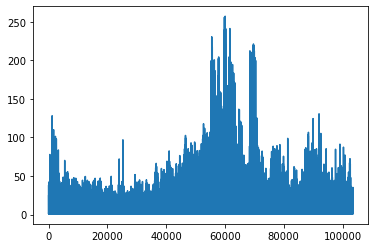

In [ ]:
plt.plot(pricevecEst)

In [ ]:
pricevecEst_ = np.empty((103496,1))
pricevecEst_[:] = np.NaN
for per in ['pre-crisis','crisis','post-crisis']:
    BOP = FBayesianOptionPricing(option_data, 
                              ['moneyness','maturity'],
                              'market price',
                              hidden_nodes = [32, 32],
                              learning_rate = 0.01,
                              batch_size = 256,
                              alpha=1,
                              beta = 0.000001)
    predvec, index, rmse, mape = BOP.cal_prediction_error(period=per, epochs = 500)
    del BOP.model
    pricevecEst_[index] = predvec

Model cannot be trained beforehand - delete trained model before calling this function!
Start training the model...
Epoch 1/500
105/105 - 3s - loss: 0.0763 - root_mean_squared_error: 15.5869 - val_loss: 0.0522 - val_root_mean_squared_error: 11.3492
Epoch 2/500
105/105 - 2s - loss: 0.0607 - root_mean_squared_error: 12.0349 - val_loss: 0.0621 - val_root_mean_squared_error: 11.6243
Epoch 3/500
105/105 - 2s - loss: 0.0590 - root_mean_squared_error: 10.4410 - val_loss: 0.0626 - val_root_mean_squared_error: 10.3630
Epoch 4/500
105/105 - 2s - loss: 0.0636 - root_mean_squared_error: 9.8790 - val_loss: 0.0720 - val_root_mean_squared_error: 10.6173
Epoch 5/500
105/105 - 2s - loss: 0.0766 - root_mean_squared_error: 10.9051 - val_loss: 0.0715 - val_root_mean_squared_error: 9.8805
Epoch 6/500
105/105 - 2s - loss: 0.0840 - root_mean_squared_error: 11.3674 - val_loss: 0.0711 - val_root_mean_squared_error: 8.8215
Epoch 7/500
105/105 - 2s - loss: 0.0747 - root_mean_squared_error: 9.5099 - val_loss: 0.0

Epoch 62/500
105/105 - 1s - loss: 0.0964 - root_mean_squared_error: 9.8507 - val_loss: 0.0913 - val_root_mean_squared_error: 8.5138
Epoch 63/500
105/105 - 1s - loss: 0.0966 - root_mean_squared_error: 9.6220 - val_loss: 0.1081 - val_root_mean_squared_error: 11.8230
Epoch 64/500
105/105 - 1s - loss: 0.1083 - root_mean_squared_error: 11.5178 - val_loss: 0.0905 - val_root_mean_squared_error: 8.3750
Epoch 65/500
105/105 - 1s - loss: 0.1001 - root_mean_squared_error: 10.0855 - val_loss: 0.0910 - val_root_mean_squared_error: 8.8210
Epoch 66/500
105/105 - 1s - loss: 0.1009 - root_mean_squared_error: 10.7052 - val_loss: 0.0938 - val_root_mean_squared_error: 9.0503
Epoch 67/500
105/105 - 1s - loss: 0.0945 - root_mean_squared_error: 9.4702 - val_loss: 0.0938 - val_root_mean_squared_error: 9.1423
Epoch 68/500
105/105 - 1s - loss: 0.0914 - root_mean_squared_error: 8.8732 - val_loss: 0.1116 - val_root_mean_squared_error: 12.4519
Epoch 69/500
105/105 - 1s - loss: 0.0948 - root_mean_squared_error: 9.5

Epoch 124/500
105/105 - 2s - loss: 0.1014 - root_mean_squared_error: 10.3746 - val_loss: 0.0990 - val_root_mean_squared_error: 10.1445
Epoch 125/500
105/105 - 1s - loss: 0.0987 - root_mean_squared_error: 9.9293 - val_loss: 0.0906 - val_root_mean_squared_error: 8.3943
Epoch 126/500
105/105 - 2s - loss: 0.0938 - root_mean_squared_error: 9.2339 - val_loss: 0.0954 - val_root_mean_squared_error: 9.6522
Epoch 127/500
105/105 - 1s - loss: 0.0928 - root_mean_squared_error: 8.8470 - val_loss: 0.0899 - val_root_mean_squared_error: 8.4121
Epoch 128/500
105/105 - 1s - loss: 0.0931 - root_mean_squared_error: 8.9859 - val_loss: 0.0938 - val_root_mean_squared_error: 9.2822
Epoch 129/500
105/105 - 1s - loss: 0.0937 - root_mean_squared_error: 9.2376 - val_loss: 0.1030 - val_root_mean_squared_error: 10.9881
Epoch 130/500
105/105 - 2s - loss: 0.1000 - root_mean_squared_error: 10.0967 - val_loss: 0.0907 - val_root_mean_squared_error: 8.5878
Epoch 131/500
105/105 - 2s - loss: 0.0939 - root_mean_squared_err

Epoch 186/500
105/105 - 1s - loss: 0.0936 - root_mean_squared_error: 9.3384 - val_loss: 0.0883 - val_root_mean_squared_error: 7.6793
Epoch 187/500
105/105 - 1s - loss: 0.0963 - root_mean_squared_error: 9.7962 - val_loss: 0.0909 - val_root_mean_squared_error: 8.8212
Epoch 188/500
105/105 - 1s - loss: 0.0950 - root_mean_squared_error: 9.4010 - val_loss: 0.0930 - val_root_mean_squared_error: 9.2052
Epoch 189/500
105/105 - 2s - loss: 0.0993 - root_mean_squared_error: 10.3295 - val_loss: 0.1014 - val_root_mean_squared_error: 10.8572
Epoch 190/500
105/105 - 1s - loss: 0.0940 - root_mean_squared_error: 9.5041 - val_loss: 0.0926 - val_root_mean_squared_error: 9.0663
Epoch 191/500
105/105 - 1s - loss: 0.0943 - root_mean_squared_error: 9.2999 - val_loss: 0.1106 - val_root_mean_squared_error: 12.3777
Epoch 192/500
105/105 - 1s - loss: 0.0925 - root_mean_squared_error: 9.2043 - val_loss: 0.0955 - val_root_mean_squared_error: 9.7724
Epoch 193/500
105/105 - 1s - loss: 0.0908 - root_mean_squared_erro

Epoch 248/500
105/105 - 1s - loss: 0.0903 - root_mean_squared_error: 9.1644 - val_loss: 0.0862 - val_root_mean_squared_error: 8.4328
Epoch 249/500
105/105 - 2s - loss: 0.0843 - root_mean_squared_error: 8.0355 - val_loss: 0.0895 - val_root_mean_squared_error: 9.1105
Epoch 250/500
105/105 - 1s - loss: 0.0845 - root_mean_squared_error: 8.1648 - val_loss: 0.0890 - val_root_mean_squared_error: 9.1238
Epoch 251/500
105/105 - 2s - loss: 0.0846 - root_mean_squared_error: 8.1892 - val_loss: 0.0831 - val_root_mean_squared_error: 7.8854
Epoch 252/500
105/105 - 1s - loss: 0.0869 - root_mean_squared_error: 8.7882 - val_loss: 0.0896 - val_root_mean_squared_error: 9.5317
Epoch 253/500
105/105 - 2s - loss: 0.0865 - root_mean_squared_error: 8.6670 - val_loss: 0.0845 - val_root_mean_squared_error: 8.3425
Epoch 254/500
105/105 - 2s - loss: 0.1011 - root_mean_squared_error: 11.3158 - val_loss: 0.0935 - val_root_mean_squared_error: 9.9065
Epoch 255/500
105/105 - 2s - loss: 0.0903 - root_mean_squared_error:

Epoch 310/500
105/105 - 1s - loss: 0.0718 - root_mean_squared_error: 6.8206 - val_loss: 0.0749 - val_root_mean_squared_error: 7.9251
Epoch 311/500
105/105 - 2s - loss: 0.0676 - root_mean_squared_error: 6.0138 - val_loss: 0.0688 - val_root_mean_squared_error: 6.3296
Epoch 312/500
105/105 - 2s - loss: 0.0695 - root_mean_squared_error: 6.4874 - val_loss: 0.0704 - val_root_mean_squared_error: 6.7885
Epoch 313/500
105/105 - 2s - loss: 0.0666 - root_mean_squared_error: 5.7002 - val_loss: 0.0658 - val_root_mean_squared_error: 5.6799
Epoch 314/500
105/105 - 2s - loss: 0.0673 - root_mean_squared_error: 6.1288 - val_loss: 0.0634 - val_root_mean_squared_error: 5.1173
Epoch 315/500
105/105 - 2s - loss: 0.0663 - root_mean_squared_error: 6.0256 - val_loss: 0.0653 - val_root_mean_squared_error: 5.5094
Epoch 316/500
105/105 - 2s - loss: 0.0653 - root_mean_squared_error: 5.6984 - val_loss: 0.0651 - val_root_mean_squared_error: 5.2068
Epoch 317/500
105/105 - 2s - loss: 0.0658 - root_mean_squared_error: 

Epoch 372/500
105/105 - 2s - loss: 0.0575 - root_mean_squared_error: 4.1526 - val_loss: 0.0571 - val_root_mean_squared_error: 4.0239
Epoch 373/500
105/105 - 2s - loss: 0.0574 - root_mean_squared_error: 4.0796 - val_loss: 0.0568 - val_root_mean_squared_error: 3.6839
Epoch 374/500
105/105 - 2s - loss: 0.0578 - root_mean_squared_error: 4.2262 - val_loss: 0.0562 - val_root_mean_squared_error: 3.7964
Epoch 375/500
105/105 - 2s - loss: 0.0586 - root_mean_squared_error: 4.6611 - val_loss: 0.0572 - val_root_mean_squared_error: 4.0099
Epoch 376/500
105/105 - 2s - loss: 0.0578 - root_mean_squared_error: 4.1694 - val_loss: 0.0586 - val_root_mean_squared_error: 4.4504
Epoch 377/500
105/105 - 2s - loss: 0.0589 - root_mean_squared_error: 4.5482 - val_loss: 0.0571 - val_root_mean_squared_error: 3.8708
Epoch 378/500
105/105 - 2s - loss: 0.0579 - root_mean_squared_error: 4.1755 - val_loss: 0.0582 - val_root_mean_squared_error: 4.4193
Epoch 379/500
105/105 - 2s - loss: 0.0580 - root_mean_squared_error: 

Epoch 434/500
105/105 - 2s - loss: 0.0561 - root_mean_squared_error: 4.0217 - val_loss: 0.0557 - val_root_mean_squared_error: 3.6125
Epoch 435/500
105/105 - 2s - loss: 0.0575 - root_mean_squared_error: 4.2287 - val_loss: 0.0567 - val_root_mean_squared_error: 4.0870
Epoch 436/500
105/105 - 2s - loss: 0.0573 - root_mean_squared_error: 4.0555 - val_loss: 0.0560 - val_root_mean_squared_error: 3.6188
Epoch 437/500
105/105 - 2s - loss: 0.0566 - root_mean_squared_error: 3.9970 - val_loss: 0.0568 - val_root_mean_squared_error: 4.1780
Epoch 438/500
105/105 - 2s - loss: 0.0573 - root_mean_squared_error: 4.2013 - val_loss: 0.0556 - val_root_mean_squared_error: 3.4364
Epoch 439/500
105/105 - 2s - loss: 0.0574 - root_mean_squared_error: 4.2064 - val_loss: 0.0557 - val_root_mean_squared_error: 3.6038
Epoch 440/500
105/105 - 2s - loss: 0.0562 - root_mean_squared_error: 4.0396 - val_loss: 0.0563 - val_root_mean_squared_error: 4.0287
Epoch 441/500
105/105 - 2s - loss: 0.0568 - root_mean_squared_error: 

Epoch 496/500
105/105 - 1s - loss: 0.0563 - root_mean_squared_error: 3.9936 - val_loss: 0.0570 - val_root_mean_squared_error: 3.9249
Epoch 497/500
105/105 - 1s - loss: 0.0569 - root_mean_squared_error: 4.1339 - val_loss: 0.0578 - val_root_mean_squared_error: 4.3762
Epoch 498/500
105/105 - 1s - loss: 0.0573 - root_mean_squared_error: 4.2552 - val_loss: 0.0567 - val_root_mean_squared_error: 3.9020
Epoch 499/500
105/105 - 1s - loss: 0.0569 - root_mean_squared_error: 4.0623 - val_loss: 0.0559 - val_root_mean_squared_error: 3.4978
Epoch 500/500
105/105 - 1s - loss: 0.0570 - root_mean_squared_error: 4.1478 - val_loss: 0.0555 - val_root_mean_squared_error: 3.6346
Model training finished.
Prediction Error - RMSE: 2.0666138321878367 MAPE: 0.600648406229905
Model cannot be trained beforehand - delete trained model before calling this function!
Start training the model...
Epoch 1/500
232/232 - 5s - loss: 0.1330 - root_mean_squared_error: 20.9745 - val_loss: 0.2205 - val_root_mean_squared_error: 2

Epoch 56/500
232/232 - 3s - loss: 0.1378 - root_mean_squared_error: 14.0165 - val_loss: 0.1623 - val_root_mean_squared_error: 17.2178
Epoch 57/500
232/232 - 3s - loss: 0.1374 - root_mean_squared_error: 13.9156 - val_loss: 0.1749 - val_root_mean_squared_error: 18.7036
Epoch 58/500
232/232 - 3s - loss: 0.1448 - root_mean_squared_error: 14.7942 - val_loss: 0.1870 - val_root_mean_squared_error: 19.7618
Epoch 59/500
232/232 - 3s - loss: 0.1356 - root_mean_squared_error: 13.6746 - val_loss: 0.2247 - val_root_mean_squared_error: 23.4752
Epoch 60/500
232/232 - 3s - loss: 0.1348 - root_mean_squared_error: 13.8116 - val_loss: 0.1702 - val_root_mean_squared_error: 18.1369
Epoch 61/500
232/232 - 3s - loss: 0.1391 - root_mean_squared_error: 14.1970 - val_loss: 0.1848 - val_root_mean_squared_error: 19.8940
Epoch 62/500
232/232 - 3s - loss: 0.1440 - root_mean_squared_error: 14.9147 - val_loss: 0.1639 - val_root_mean_squared_error: 17.3575
Epoch 63/500
232/232 - 3s - loss: 0.1377 - root_mean_squared_e

Epoch 118/500
232/232 - 3s - loss: 0.0677 - root_mean_squared_error: 6.5219 - val_loss: 0.0846 - val_root_mean_squared_error: 10.6278
Epoch 119/500
232/232 - 3s - loss: 0.0673 - root_mean_squared_error: 6.5675 - val_loss: 0.0857 - val_root_mean_squared_error: 10.9781
Epoch 120/500
232/232 - 3s - loss: 0.0671 - root_mean_squared_error: 6.5189 - val_loss: 0.0920 - val_root_mean_squared_error: 11.7403
Epoch 121/500
232/232 - 3s - loss: 0.0677 - root_mean_squared_error: 6.6974 - val_loss: 0.0780 - val_root_mean_squared_error: 9.0009
Epoch 122/500
232/232 - 3s - loss: 0.0676 - root_mean_squared_error: 6.5606 - val_loss: 0.0781 - val_root_mean_squared_error: 9.6280
Epoch 123/500
232/232 - 3s - loss: 0.0678 - root_mean_squared_error: 6.7273 - val_loss: 0.0879 - val_root_mean_squared_error: 11.2013
Epoch 124/500
232/232 - 3s - loss: 0.0663 - root_mean_squared_error: 6.1927 - val_loss: 0.0837 - val_root_mean_squared_error: 10.4629
Epoch 125/500
232/232 - 3s - loss: 0.0666 - root_mean_squared_er

Epoch 180/500
232/232 - 3s - loss: 0.0642 - root_mean_squared_error: 6.2108 - val_loss: 0.0785 - val_root_mean_squared_error: 9.7500
Epoch 181/500
232/232 - 3s - loss: 0.0646 - root_mean_squared_error: 6.3035 - val_loss: 0.0704 - val_root_mean_squared_error: 8.2508
Epoch 182/500
232/232 - 3s - loss: 0.0647 - root_mean_squared_error: 6.3332 - val_loss: 0.0734 - val_root_mean_squared_error: 8.6949
Epoch 183/500
232/232 - 3s - loss: 0.0645 - root_mean_squared_error: 6.3192 - val_loss: 0.0715 - val_root_mean_squared_error: 8.5322
Epoch 184/500
232/232 - 3s - loss: 0.0648 - root_mean_squared_error: 6.2945 - val_loss: 0.0797 - val_root_mean_squared_error: 9.8343
Epoch 185/500
232/232 - 3s - loss: 0.0637 - root_mean_squared_error: 5.9670 - val_loss: 0.0733 - val_root_mean_squared_error: 8.8273
Epoch 186/500
232/232 - 3s - loss: 0.0638 - root_mean_squared_error: 6.1881 - val_loss: 0.0749 - val_root_mean_squared_error: 8.9225
Epoch 187/500
232/232 - 3s - loss: 0.0654 - root_mean_squared_error: 

Epoch 242/500
232/232 - 3s - loss: 0.0637 - root_mean_squared_error: 6.1060 - val_loss: 0.0702 - val_root_mean_squared_error: 8.0843
Epoch 243/500
232/232 - 3s - loss: 0.0637 - root_mean_squared_error: 6.1911 - val_loss: 0.0727 - val_root_mean_squared_error: 8.5702
Epoch 244/500
232/232 - 3s - loss: 0.0624 - root_mean_squared_error: 5.9616 - val_loss: 0.0705 - val_root_mean_squared_error: 8.0434
Epoch 245/500
232/232 - 3s - loss: 0.0627 - root_mean_squared_error: 6.0496 - val_loss: 0.0695 - val_root_mean_squared_error: 8.0183
Epoch 246/500
232/232 - 3s - loss: 0.0632 - root_mean_squared_error: 6.0742 - val_loss: 0.0743 - val_root_mean_squared_error: 9.1636
Epoch 247/500
232/232 - 3s - loss: 0.0635 - root_mean_squared_error: 6.2467 - val_loss: 0.0749 - val_root_mean_squared_error: 8.9524
Epoch 248/500
232/232 - 3s - loss: 0.0635 - root_mean_squared_error: 6.2617 - val_loss: 0.0702 - val_root_mean_squared_error: 7.9498
Epoch 249/500
232/232 - 3s - loss: 0.0649 - root_mean_squared_error: 

Epoch 304/500
232/232 - 3s - loss: 0.0639 - root_mean_squared_error: 6.1675 - val_loss: 0.0778 - val_root_mean_squared_error: 9.8516
Epoch 305/500
232/232 - 3s - loss: 0.0636 - root_mean_squared_error: 6.0520 - val_loss: 0.0684 - val_root_mean_squared_error: 7.8957
Epoch 306/500
232/232 - 3s - loss: 0.0635 - root_mean_squared_error: 6.0956 - val_loss: 0.0714 - val_root_mean_squared_error: 8.7941
Epoch 307/500
232/232 - 3s - loss: 0.0646 - root_mean_squared_error: 6.3197 - val_loss: 0.0720 - val_root_mean_squared_error: 8.5746
Epoch 308/500
232/232 - 3s - loss: 0.0636 - root_mean_squared_error: 6.1680 - val_loss: 0.0760 - val_root_mean_squared_error: 9.1529
Epoch 309/500
232/232 - 3s - loss: 0.0638 - root_mean_squared_error: 6.1538 - val_loss: 0.0704 - val_root_mean_squared_error: 8.4574
Epoch 310/500
232/232 - 3s - loss: 0.0639 - root_mean_squared_error: 6.1827 - val_loss: 0.0695 - val_root_mean_squared_error: 7.7278
Epoch 311/500
232/232 - 3s - loss: 0.0640 - root_mean_squared_error: 

Epoch 366/500
232/232 - 3s - loss: 0.0642 - root_mean_squared_error: 6.2406 - val_loss: 0.0738 - val_root_mean_squared_error: 8.9094
Epoch 367/500
232/232 - 3s - loss: 0.0639 - root_mean_squared_error: 6.2111 - val_loss: 0.0837 - val_root_mean_squared_error: 11.0647
Epoch 368/500
232/232 - 3s - loss: 0.0640 - root_mean_squared_error: 6.1880 - val_loss: 0.0800 - val_root_mean_squared_error: 10.1443
Epoch 369/500
232/232 - 3s - loss: 0.0634 - root_mean_squared_error: 6.1314 - val_loss: 0.0760 - val_root_mean_squared_error: 9.4725
Epoch 370/500
232/232 - 3s - loss: 0.0630 - root_mean_squared_error: 6.0293 - val_loss: 0.0703 - val_root_mean_squared_error: 7.9844
Epoch 371/500
232/232 - 3s - loss: 0.0633 - root_mean_squared_error: 6.1741 - val_loss: 0.0774 - val_root_mean_squared_error: 9.5241
Epoch 372/500
232/232 - 3s - loss: 0.0637 - root_mean_squared_error: 6.2005 - val_loss: 0.0694 - val_root_mean_squared_error: 7.8894
Epoch 373/500
232/232 - 3s - loss: 0.0641 - root_mean_squared_error

Epoch 428/500
232/232 - 3s - loss: 0.0637 - root_mean_squared_error: 6.1890 - val_loss: 0.0795 - val_root_mean_squared_error: 9.9883
Epoch 429/500
232/232 - 3s - loss: 0.0632 - root_mean_squared_error: 6.0357 - val_loss: 0.0720 - val_root_mean_squared_error: 8.5532
Epoch 430/500
232/232 - 3s - loss: 0.0636 - root_mean_squared_error: 6.1998 - val_loss: 0.0773 - val_root_mean_squared_error: 9.6504
Epoch 431/500
232/232 - 3s - loss: 0.0636 - root_mean_squared_error: 6.2029 - val_loss: 0.0715 - val_root_mean_squared_error: 8.0760
Epoch 432/500
232/232 - 3s - loss: 0.0634 - root_mean_squared_error: 6.1718 - val_loss: 0.0713 - val_root_mean_squared_error: 8.6147
Epoch 433/500
232/232 - 3s - loss: 0.0643 - root_mean_squared_error: 6.2131 - val_loss: 0.0721 - val_root_mean_squared_error: 8.5471
Epoch 434/500
232/232 - 3s - loss: 0.0638 - root_mean_squared_error: 6.2421 - val_loss: 0.0731 - val_root_mean_squared_error: 8.6922
Epoch 435/500
232/232 - 3s - loss: 0.0634 - root_mean_squared_error: 

Epoch 490/500
232/232 - 3s - loss: 0.0650 - root_mean_squared_error: 6.3110 - val_loss: 0.0708 - val_root_mean_squared_error: 7.9085
Epoch 491/500
232/232 - 3s - loss: 0.0634 - root_mean_squared_error: 6.1430 - val_loss: 0.0724 - val_root_mean_squared_error: 8.7314
Epoch 492/500
232/232 - 3s - loss: 0.0631 - root_mean_squared_error: 6.1822 - val_loss: 0.0776 - val_root_mean_squared_error: 9.7533
Epoch 493/500
232/232 - 3s - loss: 0.0632 - root_mean_squared_error: 6.0013 - val_loss: 0.0841 - val_root_mean_squared_error: 11.1144
Epoch 494/500
232/232 - 3s - loss: 0.0643 - root_mean_squared_error: 6.3042 - val_loss: 0.0747 - val_root_mean_squared_error: 8.8408
Epoch 495/500
232/232 - 3s - loss: 0.0647 - root_mean_squared_error: 6.3919 - val_loss: 0.0783 - val_root_mean_squared_error: 9.8095
Epoch 496/500
232/232 - 3s - loss: 0.0640 - root_mean_squared_error: 6.2216 - val_loss: 0.0782 - val_root_mean_squared_error: 9.8270
Epoch 497/500
232/232 - 3s - loss: 0.0640 - root_mean_squared_error:

Epoch 50/500
371/371 - 4s - loss: 0.1499 - root_mean_squared_error: 15.2527 - val_loss: 0.1149 - val_root_mean_squared_error: 10.0135
Epoch 51/500
371/371 - 4s - loss: 0.1415 - root_mean_squared_error: 14.1013 - val_loss: 0.1190 - val_root_mean_squared_error: 10.9084
Epoch 52/500
371/371 - 4s - loss: 0.1479 - root_mean_squared_error: 14.8592 - val_loss: 0.1176 - val_root_mean_squared_error: 10.2941
Epoch 53/500
371/371 - 4s - loss: 0.1470 - root_mean_squared_error: 14.9590 - val_loss: 0.1245 - val_root_mean_squared_error: 12.3066
Epoch 54/500
371/371 - 4s - loss: 0.1448 - root_mean_squared_error: 14.7989 - val_loss: 0.1078 - val_root_mean_squared_error: 8.9014
Epoch 55/500
371/371 - 4s - loss: 0.1399 - root_mean_squared_error: 14.2285 - val_loss: 0.1089 - val_root_mean_squared_error: 9.0177
Epoch 56/500
371/371 - 4s - loss: 0.1407 - root_mean_squared_error: 14.3296 - val_loss: 0.1134 - val_root_mean_squared_error: 10.6348
Epoch 57/500
371/371 - 4s - loss: 0.1460 - root_mean_squared_err

Epoch 112/500
371/371 - 4s - loss: 0.1197 - root_mean_squared_error: 12.8168 - val_loss: 0.1009 - val_root_mean_squared_error: 8.6677
Epoch 113/500
371/371 - 4s - loss: 0.1193 - root_mean_squared_error: 12.6356 - val_loss: 0.0917 - val_root_mean_squared_error: 8.3927
Epoch 114/500
371/371 - 4s - loss: 0.1137 - root_mean_squared_error: 12.0656 - val_loss: 0.1057 - val_root_mean_squared_error: 10.3842
Epoch 115/500
371/371 - 4s - loss: 0.1209 - root_mean_squared_error: 13.1843 - val_loss: 0.0986 - val_root_mean_squared_error: 10.1263
Epoch 116/500
371/371 - 4s - loss: 0.1234 - root_mean_squared_error: 13.6333 - val_loss: 0.0976 - val_root_mean_squared_error: 9.3220
Epoch 117/500
371/371 - 4s - loss: 0.1169 - root_mean_squared_error: 12.7945 - val_loss: 0.0958 - val_root_mean_squared_error: 9.1723
Epoch 118/500
371/371 - 4s - loss: 0.1187 - root_mean_squared_error: 12.9477 - val_loss: 0.1081 - val_root_mean_squared_error: 11.4713
Epoch 119/500
371/371 - 4s - loss: 0.1245 - root_mean_squar

Epoch 174/500
371/371 - 4s - loss: 0.0692 - root_mean_squared_error: 7.0345 - val_loss: 0.0609 - val_root_mean_squared_error: 4.0778
Epoch 175/500
371/371 - 4s - loss: 0.0701 - root_mean_squared_error: 7.1653 - val_loss: 0.0603 - val_root_mean_squared_error: 4.2644
Epoch 176/500
371/371 - 4s - loss: 0.0689 - root_mean_squared_error: 6.9249 - val_loss: 0.0621 - val_root_mean_squared_error: 4.5378
Epoch 177/500
371/371 - 4s - loss: 0.0696 - root_mean_squared_error: 7.0323 - val_loss: 0.0603 - val_root_mean_squared_error: 3.8164
Epoch 178/500
371/371 - 4s - loss: 0.0695 - root_mean_squared_error: 7.0554 - val_loss: 0.0579 - val_root_mean_squared_error: 3.4733
Epoch 179/500
371/371 - 5s - loss: 0.0694 - root_mean_squared_error: 7.0543 - val_loss: 0.0591 - val_root_mean_squared_error: 3.6834
Epoch 180/500
371/371 - 5s - loss: 0.0689 - root_mean_squared_error: 6.8838 - val_loss: 0.0598 - val_root_mean_squared_error: 3.6031
Epoch 181/500
371/371 - 4s - loss: 0.0690 - root_mean_squared_error: 

Epoch 236/500
371/371 - 4s - loss: 0.0659 - root_mean_squared_error: 6.5290 - val_loss: 0.0603 - val_root_mean_squared_error: 3.7577
Epoch 237/500
371/371 - 4s - loss: 0.0663 - root_mean_squared_error: 6.6445 - val_loss: 0.0595 - val_root_mean_squared_error: 4.1698
Epoch 238/500
371/371 - 4s - loss: 0.0666 - root_mean_squared_error: 6.5743 - val_loss: 0.0608 - val_root_mean_squared_error: 3.8091
Epoch 239/500
371/371 - 4s - loss: 0.0662 - root_mean_squared_error: 6.5755 - val_loss: 0.0600 - val_root_mean_squared_error: 4.0069
Epoch 240/500
371/371 - 4s - loss: 0.0660 - root_mean_squared_error: 6.4707 - val_loss: 0.0599 - val_root_mean_squared_error: 3.9300
Epoch 241/500
371/371 - 4s - loss: 0.0663 - root_mean_squared_error: 6.5935 - val_loss: 0.0595 - val_root_mean_squared_error: 3.7660
Epoch 242/500
371/371 - 4s - loss: 0.0666 - root_mean_squared_error: 6.6563 - val_loss: 0.0599 - val_root_mean_squared_error: 4.0704
Epoch 243/500
371/371 - 4s - loss: 0.0665 - root_mean_squared_error: 

Epoch 298/500
371/371 - 4s - loss: 0.0663 - root_mean_squared_error: 6.5381 - val_loss: 0.0592 - val_root_mean_squared_error: 4.4031
Epoch 299/500
371/371 - 4s - loss: 0.0661 - root_mean_squared_error: 6.6432 - val_loss: 0.0585 - val_root_mean_squared_error: 3.9595
Epoch 300/500
371/371 - 5s - loss: 0.0661 - root_mean_squared_error: 6.6461 - val_loss: 0.0589 - val_root_mean_squared_error: 4.0576
Epoch 301/500
371/371 - 5s - loss: 0.0653 - root_mean_squared_error: 6.4354 - val_loss: 0.0582 - val_root_mean_squared_error: 3.1747
Epoch 302/500
371/371 - 4s - loss: 0.0665 - root_mean_squared_error: 6.7314 - val_loss: 0.0621 - val_root_mean_squared_error: 5.0110
Epoch 303/500
371/371 - 4s - loss: 0.0673 - root_mean_squared_error: 6.8494 - val_loss: 0.0598 - val_root_mean_squared_error: 4.1403
Epoch 304/500
371/371 - 4s - loss: 0.0660 - root_mean_squared_error: 6.5036 - val_loss: 0.0591 - val_root_mean_squared_error: 4.0523
Epoch 305/500
371/371 - 4s - loss: 0.0666 - root_mean_squared_error: 

Epoch 360/500
371/371 - 4s - loss: 0.0670 - root_mean_squared_error: 6.7450 - val_loss: 0.0601 - val_root_mean_squared_error: 4.1069
Epoch 361/500
371/371 - 4s - loss: 0.0665 - root_mean_squared_error: 6.5499 - val_loss: 0.0594 - val_root_mean_squared_error: 3.7858
Epoch 362/500
371/371 - 4s - loss: 0.0670 - root_mean_squared_error: 6.7339 - val_loss: 0.0588 - val_root_mean_squared_error: 3.8820
Epoch 363/500
371/371 - 4s - loss: 0.0670 - root_mean_squared_error: 6.7301 - val_loss: 0.0598 - val_root_mean_squared_error: 4.4117
Epoch 364/500
371/371 - 4s - loss: 0.0662 - root_mean_squared_error: 6.5939 - val_loss: 0.0587 - val_root_mean_squared_error: 3.8719
Epoch 365/500
371/371 - 4s - loss: 0.0666 - root_mean_squared_error: 6.6666 - val_loss: 0.0588 - val_root_mean_squared_error: 3.5084
Epoch 366/500
371/371 - 4s - loss: 0.0659 - root_mean_squared_error: 6.4821 - val_loss: 0.0589 - val_root_mean_squared_error: 3.6710
Epoch 367/500
371/371 - 4s - loss: 0.0659 - root_mean_squared_error: 

Epoch 422/500
371/371 - 4s - loss: 0.0662 - root_mean_squared_error: 6.6655 - val_loss: 0.0615 - val_root_mean_squared_error: 4.4975
Epoch 423/500
371/371 - 4s - loss: 0.0660 - root_mean_squared_error: 6.5605 - val_loss: 0.0579 - val_root_mean_squared_error: 3.7643
Epoch 424/500
371/371 - 4s - loss: 0.0659 - root_mean_squared_error: 6.5529 - val_loss: 0.0594 - val_root_mean_squared_error: 3.7654
Epoch 425/500
371/371 - 4s - loss: 0.0672 - root_mean_squared_error: 6.7742 - val_loss: 0.0602 - val_root_mean_squared_error: 3.7461
Epoch 426/500
371/371 - 4s - loss: 0.0670 - root_mean_squared_error: 6.6535 - val_loss: 0.0621 - val_root_mean_squared_error: 4.6127
Epoch 427/500
371/371 - 4s - loss: 0.0663 - root_mean_squared_error: 6.5946 - val_loss: 0.0570 - val_root_mean_squared_error: 3.2265
Epoch 428/500
371/371 - 4s - loss: 0.0663 - root_mean_squared_error: 6.5937 - val_loss: 0.0589 - val_root_mean_squared_error: 4.2904
Epoch 429/500
371/371 - 4s - loss: 0.0664 - root_mean_squared_error: 

Epoch 484/500
371/371 - 4s - loss: 0.0664 - root_mean_squared_error: 6.6407 - val_loss: 0.0601 - val_root_mean_squared_error: 4.1331
Epoch 485/500
371/371 - 4s - loss: 0.0670 - root_mean_squared_error: 6.6909 - val_loss: 0.0565 - val_root_mean_squared_error: 3.4560
Epoch 486/500
371/371 - 4s - loss: 0.0670 - root_mean_squared_error: 6.6286 - val_loss: 0.0599 - val_root_mean_squared_error: 4.0257
Epoch 487/500
371/371 - 4s - loss: 0.0669 - root_mean_squared_error: 6.7241 - val_loss: 0.0596 - val_root_mean_squared_error: 4.8107
Epoch 488/500
371/371 - 4s - loss: 0.0665 - root_mean_squared_error: 6.5886 - val_loss: 0.0604 - val_root_mean_squared_error: 4.2460
Epoch 489/500
371/371 - 4s - loss: 0.0661 - root_mean_squared_error: 6.5734 - val_loss: 0.0601 - val_root_mean_squared_error: 3.5894
Epoch 490/500
371/371 - 4s - loss: 0.0660 - root_mean_squared_error: 6.6177 - val_loss: 0.0591 - val_root_mean_squared_error: 3.8688
Epoch 491/500
371/371 - 4s - loss: 0.0663 - root_mean_squared_error: 

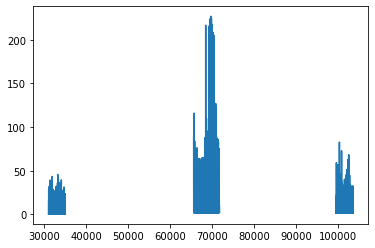

In [ ]:
plt.plot(pricevecEst_)